In [1]:
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive')

In [2]:
import sys
sys.version
#Import Libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn
from random import shuffle
#TF Version
tf.__version__

#np.random.seed(1)
#tf.random.set_random_seed(1)
#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore",category=FutureWarning)
#    import h5py

#num_periods_output = 4 #to predict
#num_periods_input=8 #input

ALL_Test_Data=[]
ALL_Test_Prediction=[]
Event_Based_StartIndex=0
Number_of_EventBased=0
Number_of_TimeFeatures=15


No_Of_weeks=1

<h5>Preprocessing data</h5>

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

def preprocessing(df_,num_features):
    
    #cols=df.columns
    #df_part=df[['Occupancy_m5', 'Occupancy_m6', 'Occupancy_m7']]
    #print(cols[20:])
    
    # get year, month,Day,Hour,Minute
    df_['LastUpdated'] = pd.to_datetime(df_['LastUpdated'])
    df_['Year'] = df_['LastUpdated'].dt.year
    df_['Month'] = df_['LastUpdated'].dt.month
    df_['Day'] = df_['LastUpdated'].dt.day
    df_['Hour'] = df_['LastUpdated'].dt.hour
    df_['Minute'] = df_['LastUpdated'].dt.minute
    
    #,'Month','Day','Hour','Minute'
    # select features
    df=df_[['ID','Occ_percent','Month','Day','Hour','Minute',
           'temperature','dew_point','humidity','wind_speed',
           'feels_like','Events_Football_City','Events_Football_Derby',
           'Events_Football_Aston','Events_Rugby']]
    
    cols=df.columns
    print(cols[20:]) 
    
    ################################################encoding########################
    df['Occ_percent'] = pd.to_numeric(df['Occ_percent'],errors='coerce')
    df['Occ_percent'] = df['Occ_percent'].abs()
    
    
    
    Number_Of_Features=num_features
    df=df.values
    df = df.astype('float32')
    split=num_periods_output+num_periods_input
    
    
    ##################################SPLIT##############################################
    print('LEN DF BEFORE CUTTING ANYTHING',len(df))
     ########################## SPLITTING FOR TESTING & VALIDATION ##########################
    #test_len=np.floor(len(df)*0.2)
    test_val_len=np.floor(len(df)*0.2)
    #mod=test_len%(num_periods_input+num_periods_output)
    mod=test_val_len%(num_periods_input+num_periods_output)
    #let thelength be divisable by 12
    test_val_len=int(test_val_len-mod)
    Test_Val=df[(len(df)-test_val_len):,:]
    
    ############################ VALIDATION & TESTING ##################################
    valid_len=np.floor(len(Test_Val)*0.5)
    Valid=Test_Val[0:(len(Test_Val)-int(valid_len)),:]
    Test=Test_Val[(len(Test_Val)-int(valid_len)):,:]
    #Valid=Test[0:(len(Test)-int(valid_len)),:]
    
    
    ########################### SPLITTING FOR TRAIN ###########################
    
    new_cutted_df=df[:(len(df)-test_val_len),:]
    Start_train_index=17*7*No_Of_weeks
    #Start_train_index=12*24*1 # 1 day
    Start_train_index=np.floor(Start_train_index)
    Start_train_index=int(Start_train_index)
    print('instances',Start_train_index)
    Train=new_cutted_df[len(new_cutted_df)-Start_train_index:,:]
    print('len new_cutted - start_train_ind',len(new_cutted_df)-Start_train_index)
    train_len=len(Train)
    mod=train_len%(num_periods_input+num_periods_output)
    #let thelength be divisable by 12
    train_len=int(train_len-mod)
    Train=Train[0:train_len,:]
    print('len Train',len(Train))
   
        
    #############################  Normalization on train and validation separatly  #############
     
    ID_Train=Train[:,0]
    Train=np.delete(Train,[0],1)
    #x_batches=x_batches.drop(columns=['ID'], axis=1)
    occ_Train=Train[:,0]
    Train=np.delete(Train,[0],1)
    #x_batches=x_batches.drop(columns=['Occupancy'], axis=1)
    #normalizing data
    Train = Train.astype('float32')
    normalizer = Normalizer().fit(Train)
    Train=normalizer.transform(Train)
    
    ID_Valid=Valid[:,0]
    Valid=np.delete(Valid,[0],1)
    #X_test=X_test.drop(columns=['ID'], axis=1)
    occ_Valid=Valid[:,0]
    Valid=np.delete(Valid,[0],1)
    #X_test=X_test.drop(columns=['Occupancy'], axis=1)
    Valid = Valid.astype('float32')
    Valid=normalizer.transform(Valid)
    #------------------
    ID_Train=np.reshape(ID_Train,(len(ID_Train),1))
    occ_Train=np.reshape(occ_Train,(len(occ_Train),1))
    
    Train=np.append(occ_Train, Train, axis=1)
    Train=np.append(ID_Train, Train, axis=1)
    #------------------
    ID_Valid=np.reshape(ID_Valid,(len(ID_Valid),1))
    occ_Valid=np.reshape(occ_Valid,(len(occ_Valid),1))
    
    Valid=np.append(occ_Valid,Valid, axis=1)
    Valid=np.append(ID_Valid, Valid, axis=1)

    ############################################ TRAIN minibatches ##################################
    
    end=len(Train)
    start=0
    next=0
    x_batches=[]
    y_batches=[]
    
    count=0
    #print('lennnn',len(Train))
    while next+(num_periods_input+num_periods_output)<end:
        next=start+num_periods_input
        x_batches.append(Train[start:next,:])
        y_batches.append(Train[next:next+num_periods_output,1])
        start=start+1
    y_batches=np.asarray(y_batches)
    y_batches = y_batches.reshape(-1, num_periods_output, 1)   
    x_batches=np.asarray(x_batches)
    x_batches = x_batches.reshape(-1, num_periods_input, Number_Of_Features)   
    print('len x_batches ',len(x_batches))
    
    ############################################ VALID minibatches ##################################
    
    end_val=len(Valid)
    start_val=0
    next_val=0
    x_validbatches=[]
    y_validbatches=[]
    
    while next_val+(num_periods_input+num_periods_output)<end_val:
        next_val=start_val+num_periods_input
        x_validbatches.append(Valid[start_val:next_val,:])
        y_validbatches.append(Valid[next_val:next_val+num_periods_output,1])
        start_val=start_val+1
    y_validbatches=np.asarray(y_validbatches)
    y_validbatches = y_validbatches.reshape(-1, num_periods_output, 1)   
    x_validbatches=np.asarray(x_validbatches)
    x_validbatches = x_validbatches.reshape(-1, num_periods_input, Number_Of_Features)   

    ###########################################TEST#####################################
    
    ID_Test=Test[:,0]
    Test=np.delete(Test,[0],1)
    #X_test=X_test.drop(columns=['ID'], axis=1)
    occ_Test=Test[:,0]
    Test=np.delete(Test,[0],1)
    #X_test=X_test.drop(columns=['Occupancy'], axis=1)
    Test = Test.astype('float32')
    Test=normalizer.transform(Test)
    
    #------------------
    ID_Test=np.reshape(ID_Test,(len(ID_Test),1))
    occ_Test=np.reshape(occ_Test,(len(occ_Test),1))
    
    Test=np.append(occ_Test,Test, axis=1)
    Test=np.append(ID_Test, Test, axis=1)
    
    ############################################ TEST minibatches ##################################
    end_test=len(Test)
    start_test=0
    next_test=0
    x_testbatches=[]
    y_testbatches=[]
    
    
    #print('lennnn',len(Train))
    while next_test+(num_periods_input+num_periods_output)<end_test:
        next_test=start_test+num_periods_input
        x_testbatches.append(Test[start_test:next_test,:])
        y_testbatches.append(Test[next_test:next_test+num_periods_output,1])
        start_test=start_test+1
    y_testbatches=np.asarray(y_testbatches)
    y_testbatches = y_testbatches.reshape(-1, num_periods_output, 1)   
    x_testbatches=np.asarray(x_testbatches)
    x_testbatches = x_testbatches.reshape(-1, num_periods_input, Number_Of_Features) 
    print('len Test',len(Test))
    print('len xTestbatches',len(x_testbatches))
    ######################## Sampling##########################################
    
    #x_batches, y_batches, x_validbatches, y_validbatches, x_testbatches, y_testbatches
    
    return x_batches, y_batches,x_validbatches, y_validbatches, x_testbatches, y_testbatches

In [4]:
def load_locationfiles(path,loc_id):
    filename=path + '/Birm'+str(loc_id)+'.csv'
    print(filename)
    data_loc=pd.read_csv(filename)
    #mod=len(data_loc)%(num_periods_input+num_periods_output)
    #let thelength be divisable by 12
    #data_loc=data_loc[:len(data_loc)-mod]
    return data_loc

# Creating Tensorflow Graph + Run Session

##### Training Params:

In [5]:
##### Prediction Params #####
num_periods_output = 2    #to predict (1h)
#12
num_periods_input= 4      #input (2h)
#24
#num_periods = 4           #number of periods per vector we are using to predict one period ahead

##### Graph Params #####
inputs = Number_of_TimeFeatures-1                #number of vectors submitted
hidden = 128               #number of neurons we will recursively work through, can be changed to improve accuracy
hidden_event=128
output = 1                 #number of output vectors
num_layers=1
num_layers_EventBased=1

##### Static Features #####
Number_Of_Static_Features=30
no_sequences=128            #re-iterating factor for static features

##### Optimization Params #####
batchsize=128
#init_epoch=3              #number of epochs using the constant init_learning_rate
#initial_LR=0.0003
#learning_rate_decay=0.95
l_rate = 0.00005         #small learning rate so we don't overshoot the minimum
keep_prob_static=0.7       #number of epochs using the constant init_learning_rate
keep_prob_event=0.7
lamda=0.01                #regularization param 
keep_probab=0.9            #(1-dropout_rate)
keep_prob_testval=1.0      #(1-dropout_rate) for testing and validation runs
epochs = 600               #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
#250                


#where to save logs
#logs_path = '/tmp/tf_logs_3_LSTM_Fully_0410_ConnEnd_Shift_FSTop3/example/'

In [6]:
# model decaying learning rate, instead of fixed one
#def compute_LR(init_epoch,max_epoch,learning_rate_decay,init_learning_rate):
#    LR_to_use = [
#        init_learning_rate * (
#            learning_rate_decay ** max(float(i+1-init_epoch),0.0)
#        ) for i in range(max_epoch)
#    ]
#    print("Middle LR:", LR_to_use[len(LR_to_use) // 2])
#    return LR_to_use

In [7]:
IDs=np.arange(30)
Static_Features=np.zeros((30,30))
Static_Features[np.arange(30),IDs]=1

In [8]:
train_mse=[]
validation_mse=[]
test_mse=[]
tf.reset_default_graph()   #We didn't have any previous graph objects running, but this would reset the graphs


#=============================LSTM part===========================================

lstm_graph=tf.Graph()
with lstm_graph.as_default():
    X = tf.placeholder(tf.float32, [None, num_periods_input, inputs])   #create variable objects
    y = tf.placeholder(tf.float32, [None, num_periods_output, output])
    learning_rate=tf.placeholder(tf.float32, None)
    #batchsize = tf.placeholder(tf.int16)
    #dropout = tf.placeholder(tf.float32)
    is_train = tf.placeholder(tf.bool)
    #EventBased_X=tf.placeholder(tf.float32, [None,num_periods_input,Number_of_EventBased])
    static_X = tf.placeholder(tf.float32, [None,Number_Of_Static_Features])
    keep_prob = tf.placeholder(tf.float32, None)

    
    #====================================================================================
    #=========================Static Features part=======================================
    '''
    Layer1 = tf.layers.dense(static_X, units=100,activation=tf.nn.relu)  
    Static_Output_1 = tf.layers.dense(Layer1,units= 50,activation=tf.nn.relu) 
    Static_Output = tf.nn.dropout(Static_Output_1,keep_prob=keep_prob_static) # dropout 
    #===================================== Combine before LSTM ===========================
    Static_Output=tf.reshape(Static_Output, [-1, num_periods_input,50])

    Combined_output=tf.concat([X,Static_Output],2)
    '''
    Static_Output=tf.reshape(static_X, [-1, num_periods_input,Number_Of_Static_Features])
    Combined_output=tf.concat([X,Static_Output],2)
    #========================================= **Time CNN** ===================================
    with tf.variable_scope('Time'):
        conv1 = tf.layers.conv1d(inputs=Combined_output, filters=128, kernel_size=8, padding="same", activation=tf.nn.relu)
        # Pooling Layer #1
        pool1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=1)
        conv2 = tf.layers.conv1d(inputs=pool1, filters=128, kernel_size=8, padding="same", activation=tf.nn.relu)
        flat=tf.contrib.layers.flatten(conv2)
        ####################  Fully connected after CNN #################################
        #flat = tf.reshape(flat, [-1,(hidden_event*num_periods_input)])# to be able to concat. the static features
        CNN_Output_1= tf.layers.dense(flat, units=100,activation=tf.nn.relu)  
        CNN_Output = tf.nn.dropout(CNN_Output_1,keep_prob=keep_probab)
    #========================CNN Event Based============================================
    '''with tf.variable_scope('Event'):
        conv1_event = tf.layers.conv1d(inputs=EventBased_X, filters=128, kernel_size=5, padding="same", activation=tf.nn.relu)
        # Pooling Layer #1
        pool1_event = tf.layers.max_pooling1d(inputs=conv1_event, pool_size=2, strides=1)
        conv2_event = tf.layers.conv1d(inputs=pool1_event, filters=64, kernel_size=5, padding="same", activation=tf.nn.relu)
        flat=tf.contrib.layers.flatten(conv2_event)
        ####################  Fully connected after CNN #################################
        #flat = tf.reshape(flat, [-1,(hidden_event*num_periods_input)])# to be able to concat. the static features
        CNN_Output_event_1= tf.layers.dense(flat, units=100,activation=tf.nn.relu)  
        CNN_Output_event = tf.nn.dropout(CNN_Output_event_1,keep_prob=keep_prob_event)
    '''
        #====================================================================================
    #=========================Combination part===========================================

    #Combined_output=tf.concat([CNN_Output,CNN_Output_event],1)
    #Combined_output=tf.multiply(LSTM_Output,LSTM_Output_event)
    stacked_outputs = tf.layers.dense(CNN_Output, units=num_periods_output) #specify the type of layer (dense)
    outputs = tf.reshape(stacked_outputs, [-1, num_periods_output, output])          #shape of results
    #Regularization part
    tv = tf.trainable_variables()
    regularization_cost = tf.reduce_sum([ tf.nn.l2_loss(v) for v in tv ])
    Error=tf.square(outputs - y)
    #Total_err=Error+regularization_cost
    loss = tf.reduce_mean(tf.square(outputs - y))+ lamda*regularization_cost   #define the cost function which evaluates the quality of our model
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
    gvs = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
    
    #opt to get gradient info:
    grads=tf.gradients(loss,tv)
    grads=list(zip(grads,tv))
    
    training_op = optimizer.apply_gradients(capped_gvs)
    #training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 
    
    #Before running session, set variables to track in Tensorboard
    #with lstm_graph.as_default():
    saver = tf.train.Saver()
    #Creat Summary to monitor scalar values (loss):
    #tf.summary.scalar("loss", loss)
    
    # Create a summary to monitor prediction tensor
    #tf.summary.histogram("Prediction", predictions)
    
    # Gradient Info
    for var in tv:
        tf.summary.histogram(var.name,var)
    
    # Merge all summaries into a single op
    merged_summary_op = tf.summary.merge_all()

#====================================================================================

def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    #batch_size=
    X_returned=[]
    Y_returned=[]
    for start in range(0, len(features), batch_size):
        if (start + batch_size)>len(features):
            break
        else:
            end = start + batch_size
        X_returned.append(features[start:end])
        Y_returned.append(labels[start:end])
    return X_returned, Y_returned


# COMPUTE LEARNING RATE schedule beforehand
#LR_schedule = compute_LR(init_epoch,epochs,learning_rate_decay,initial_LR) 
with tf.Session(graph=lstm_graph) as sess:    
    
    init = tf.global_variables_initializer()           #initialize all the variables
    init.run()
    
    # creating the writer inside the session
    #writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    #### LOOP OVER LOCATIONS ####
    data_path=r'D:\Users\danie\Desktop\jupyter_notebooks\Project\Birm_Data_Events'
    #r'D:\Users\danie\Desktop\jupyter_notebooks\Project\Birm_Data'
    #r'/content/drive/My Drive/With_historical'
    #r'/home/shero/Desktop/OurProject/BanesData/Model/occupation_loc/'
    data_All=pd.DataFrame()
    x_batches_Full=[]
    y_batches_Full=[]
    X_Valid_Full=[]
    Y_Valid_Full=[]
    X_Test_Full=[]
    Y_Test_Full=[]
    range_list=[x for x in range(1,31) if x != 8 and x!=21]
    for loc_id in range_list:
        #========
        data=load_locationfiles(data_path,loc_id)
        header=list(data.columns.values)
        data=pd.DataFrame(data,columns=header)
        x_batches, y_batches, X_Valid, Y_Valid,X_Test,Y_Test=preprocessing(data,(Number_of_TimeFeatures+Number_of_EventBased))
        #===============================
        for element1 in (x_batches):
            x_batches_Full.append(element1)
            
        for element2 in (y_batches):
            y_batches_Full.append(element2)
            
        for element3 in (X_Valid):
            X_Valid_Full.append(element3)
            
        for element4 in (Y_Valid):
            Y_Valid_Full.append(element4)
            
        for element5 in (X_Test):
            X_Test_Full.append(element5)
            
        for element6 in (Y_Test):
            Y_Test_Full.append(element6)            
    
    for ep in range(epochs):
        #CALCULATE LR TO USE!!
        #curr_lr=LR_schedule[ep]
        Training_Error=[]
        #even though NOT SHUFFLED YET
        shuffled_batch_features,shuffled_batch_y=batch_features_labels(x_batches_Full,y_batches_Full,batchsize)
        #---------------------shuffle minibatches X and Y together-------------------------------------
        combined = list(zip(shuffled_batch_features, shuffled_batch_y))
        random.shuffle(combined)
        shuffled_batch_features[:], shuffled_batch_y[:] = zip(*combined)
        #===========================================================================================
        print(len(shuffled_batch_features))
        
        for i in range(0,len(shuffled_batch_features)): 
            #print('====================')
            batch_features=shuffled_batch_features[i]
            #print(batch_features)
            batch_y=shuffled_batch_y[i]
            static=[]
            Event_Based=[]
            #print('Before drop',batch_features[0][0][0])
            for h in range(0,no_sequences):
                Event_window=[]
                for k in range(0,num_periods_input):
                    loc_id=int(batch_features[h][k][0])
                    static.append(Static_Features[loc_id-1][:]) # 
                    #Event_window.append(batch_features[h][k][Event_Based_StartIndex:])
                #Event_Based.append(Event_window)
                
            #EventBased_EndIndex=Event_Based_StartIndex+Number_of_EventBased
            #Event_Based_index=list(range(Event_Based_StartIndex, EventBased_EndIndex))
            #batch_features=np.delete(batch_features,Event_Based_index, axis=2)
            batch_features=np.delete(batch_features,[0], axis=2) 
            
            #print('X',len(batch_features))
            #print('Y',len(batch_y[0]))
            _,Train_Batch_error,summary=sess.run([training_op,Error,merged_summary_op],
                                                 feed_dict={
                                                     keep_prob:keep_probab,
                                                     X: batch_features,
                                                     y: batch_y,
                                                     learning_rate: l_rate,
                                                     static_X:static}) 
            Training_Error.append(Train_Batch_error)
            
        
        #write logs (per epoch)
        #writer.add_summary(summary, ep)
        
        if ep % 3 == 0:
            ################  evaluate training error
            #print('Length of whole:',len(Training_Error),'Length of each: ',len(Training_Error[0][0]))
            Sum_train=np.sum(Training_Error,axis=2)
            Sum_train_1=np.sum(Sum_train,axis=1)
            Sum_train_2=np.sum(Sum_train_1,axis=0)
            Mean_train=Sum_train_2/(len(Training_Error)*batchsize*num_periods_output)
            print("epoch:",int(ep+1))
            print("\tRMSE Training:", (Mean_train)**0.5)
            #mse = loss.eval(feed_dict={
            #                              X: batch_features,
            #                             y: batch_y,
            #                            static_X:static_train,
            #                           is_train:True})
            train_mse.append((Mean_train)**0.5)
                
            
            Validation_Error=[]
            unshuffled_valid_batch_features,unshuffled_valid_batch_y=batch_features_labels(X_Valid_Full,Y_Valid_Full,batchsize)

            for i in range(0,len(unshuffled_valid_batch_features)):
                batch_features_valid=unshuffled_valid_batch_features[i]
                #print(batch_features)
                batch_y_valid=unshuffled_valid_batch_y[i]
                static_Valid=[]
                Event_Based_Valid=[]
                #print('Before drop',batch_features[0][0][0])
                for h in range(0,no_sequences):
                    Event_window_valid=[]
                    for k in range(0,num_periods_input):
                        loc_id=int(batch_features_valid[h][k][0])
                        static_Valid.append(Static_Features[loc_id-1][:]) # 
                        #Event_window_valid.append(batch_features_valid[h][k][Event_Based_StartIndex:])
                    #Event_Based_Valid.append(Event_window_valid)
                    
                #EventBased_EndIndex=Event_Based_StartIndex+Number_of_EventBased
                #Event_Based_index=list(range(Event_Based_StartIndex, EventBased_EndIndex))
                #batch_features_valid=np.delete(batch_features_valid,Event_Based_index, axis=2)
                batch_features_valid=np.delete(batch_features_valid,[0], axis=2)
                
                
                y_predict,Valid_error_batch=sess.run([outputs,Error], 
                                                     feed_dict={
                                                     keep_prob:keep_prob_testval,
                                                     X: batch_features_valid, 
                                                     y: batch_y_valid,
                                                     static_X:static_Valid
                                                     })
                #static_X:static_Valid
                #print('Valid_error_batch',Valid_error_batch)
                Validation_Error.append(Valid_error_batch)
            
            Sum_valid=np.sum(Validation_Error,axis=2)
            Sum_valid_1=np.sum(Sum_valid,axis=1)
            Sum_valid_2=np.sum(Sum_valid_1,axis=0)
            '''print('Sum_train shape:',Sum_valid.shape)
            print('Sum_train_1 shape:',Sum_valid_1.shape)
            print('Sum_train_2 shape:',Sum_valid_2.shape)'''
            Mean_valid=Sum_valid_2/(len(Validation_Error)*batchsize*num_periods_output)
            print("\tRMSE Validation:", (Mean_valid)**0.5)
            #mse = loss.eval(feed_dict={
            #                              X: batch_features,
            #                             y: batch_y,
            #                            static_X:static_train,
            #                           is_train:True})
            #train_mse.append((Mean_train)**0.5)
            
            validation_mse.append((Mean_valid)**0.5)
              
    # save training session --> TO RESTORE
    saver.save(sess,"checkpoints-conn_beg/har.ckpt")
    print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tf_logs_1_LSTM_Fully_1110_ConnBeg_Shift_FS4/example " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling1D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Summary name Time/conv1d/kernel:0 is illegal; using Time/conv1d/kernel_0 instead.
INFO:tensorflow:Summary name Time/conv1d/bias:0 is illegal; using Time/conv1d/bias_0 instead.
INFO:tensorflow:Summary name Time/conv1d_1/kernel:0 is illegal; using Time/conv1d_1/kernel_0 instead.
INFO:tensorflow:Summary name Time/conv1d_1/bias:0 is illegal; using Time/conv1d_1/bias_0 instead.
INFO:tensorflow:Summary name Time/dense/kernel:0 is illegal; using Time/dense/kernel_0 instead.
INFO:tensorflow:Summary name

D:\Users\danie\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Users\danie\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Users\danie\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

LEN DF BEFORE CUTTING ANYTHING 1276
instances 336
len new_cutted - start_train_ind 688
len Train 336
len x_batches  327
len Test 126
len xTestbatches 117
D:\Users\danie\Desktop\jupyter_notebooks\Project\Birm_Data_Events/Birm11.csv
Index([], dtype='object')
LEN DF BEFORE CUTTING ANYTHING 1312
instances 336
len new_cutted - start_train_ind 718
len Train 336
len x_batches  327
len Test 129
len xTestbatches 120
D:\Users\danie\Desktop\jupyter_notebooks\Project\Birm_Data_Events/Birm12.csv
Index([], dtype='object')
LEN DF BEFORE CUTTING ANYTHING 1312
instances 336
len new_cutted - start_train_ind 718
len Train 336
len x_batches  327
len Test 129
len xTestbatches 120
D:\Users\danie\Desktop\jupyter_notebooks\Project\Birm_Data_Events/Birm13.csv
Index([], dtype='object')
LEN DF BEFORE CUTTING ANYTHING 1292
instances 336
len new_cutted - start_train_ind 698
len Train 336
len x_batches  327
len Test 129
len xTestbatches 120
D:\Users\danie\Desktop\jupyter_notebooks\Project\Birm_Data_Events/Birm14.cs

D:\Users\danie\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Users\danie\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Users\danie\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

LEN DF BEFORE CUTTING ANYTHING 1186
instances 336
len new_cutted - start_train_ind 616
len Train 336
len x_batches  327
len Test 117
len xTestbatches 108
D:\Users\danie\Desktop\jupyter_notebooks\Project\Birm_Data_Events/Birm20.csv
Index([], dtype='object')
LEN DF BEFORE CUTTING ANYTHING 1204
instances 336
len new_cutted - start_train_ind 628
len Train 336
len x_batches  327
len Test 120
len xTestbatches 111
D:\Users\danie\Desktop\jupyter_notebooks\Project\Birm_Data_Events/Birm22.csv
Index([], dtype='object')
LEN DF BEFORE CUTTING ANYTHING 1204
instances 336
len new_cutted - start_train_ind 628
len Train 336
len x_batches  327
len Test 120
len xTestbatches 111
D:\Users\danie\Desktop\jupyter_notebooks\Project\Birm_Data_Events/Birm23.csv
Index([], dtype='object')
LEN DF BEFORE CUTTING ANYTHING 1312
instances 336
len new_cutted - start_train_ind 718
len Train 336
len x_batches  327
len Test 129
len xTestbatches 120
D:\Users\danie\Desktop\jupyter_notebooks\Project\Birm_Data_Events/Birm24.cs

D:\Users\danie\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Users\danie\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Users\danie\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

len x_batches  327
len Test 129
len xTestbatches 120
D:\Users\danie\Desktop\jupyter_notebooks\Project\Birm_Data_Events/Birm30.csv
Index([], dtype='object')
LEN DF BEFORE CUTTING ANYTHING 1312
instances 336
len new_cutted - start_train_ind 718
len Train 336
len x_batches  327
len Test 129
len xTestbatches 120
71
epoch: 1
	RMSE Training: [48.158527]
	RMSE Validation: [35.417545]
71
71
71
epoch: 4
	RMSE Training: [14.959077]
	RMSE Validation: [14.391857]
71
71
71
epoch: 7
	RMSE Training: [12.272125]
	RMSE Validation: [11.861398]
71
71
71
epoch: 10
	RMSE Training: [11.525753]
	RMSE Validation: [11.359893]
71
71
71
epoch: 13
	RMSE Training: [11.105846]
	RMSE Validation: [11.024208]
71
71
71
epoch: 16
	RMSE Training: [10.931732]
	RMSE Validation: [10.955901]
71
71
71
epoch: 19
	RMSE Training: [10.655383]
	RMSE Validation: [10.439729]
71
71
71
epoch: 22
	RMSE Training: [10.467691]
	RMSE Validation: [10.528772]
71
71
71
epoch: 25
	RMSE Training: [10.283734]
	RMSE Validation: [10.098607]
71
71


71
71
epoch: 313
	RMSE Training: [7.838568]
	RMSE Validation: [8.154632]
71
71
71
epoch: 316
	RMSE Training: [7.8222623]
	RMSE Validation: [8.2239]
71
71
71
epoch: 319
	RMSE Training: [7.8299613]
	RMSE Validation: [8.225499]
71
71
71
epoch: 322
	RMSE Training: [7.910803]
	RMSE Validation: [7.9952807]
71
71
71
epoch: 325
	RMSE Training: [7.846493]
	RMSE Validation: [8.656743]
71
71
71
epoch: 328
	RMSE Training: [7.7930984]
	RMSE Validation: [8.266333]
71
71
71
epoch: 331
	RMSE Training: [7.78491]
	RMSE Validation: [8.098727]
71
71
71
epoch: 334
	RMSE Training: [7.7667375]
	RMSE Validation: [8.0861]
71
71
71
epoch: 337
	RMSE Training: [7.7369814]
	RMSE Validation: [8.495846]
71
71
71
epoch: 340
	RMSE Training: [7.8678384]
	RMSE Validation: [8.1615]
71
71
71
epoch: 343
	RMSE Training: [7.761395]
	RMSE Validation: [8.252743]
71
71
71
epoch: 346
	RMSE Training: [7.859812]
	RMSE Validation: [8.119978]
71
71
71
epoch: 349
	RMSE Training: [7.7416253]
	RMSE Validation: [8.171604]
71
71
71
epoch

In [9]:
print('min training RMSE:',min(train_mse))
print('min validation RMSE:',min(validation_mse))

min training RMSE: [6.996079]
min validation RMSE: [7.704432]


### Plot Training + Validation

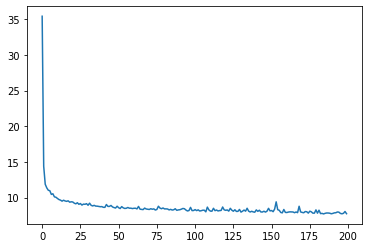

In [10]:
plt.plot(validation_mse)

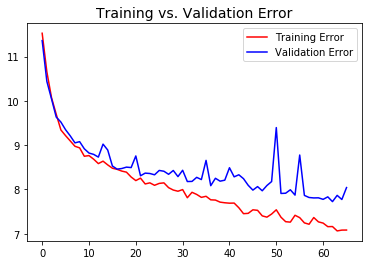

In [11]:
Train_draw=[]
Valid_draw=[]
for i in range(0,len(train_mse)):
  if i%3==0:
    Train_draw.append(train_mse[i])
    Valid_draw.append(validation_mse[i])

plt.title("Training vs. Validation Error", fontsize=14)
#plt.legend(loc="lower right")
plt.plot(Train_draw[1:], markersize=10, label="Training Error",color='red')
plt.plot(Valid_draw[1:], markersize=10, label="Validation Error",color='blue')
plt.legend(loc="upper right")
plt.savefig('Training vs Testing Error.png')
plt.show()

### Testing Part

In [12]:
Test_Error=[]
with tf.Session(graph=lstm_graph) as sess: 
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-conn_beg'))
    test_batch_features,test_batch_y=batch_features_labels(X_Test_Full,Y_Test_Full,batchsize)
    #---------------------shuffle minibatches X and Y together-------------------------------------
    #combined = list(zip(shuffled_batch_features, shuffled_batch_y))
    #random.shuffle(combined)
    #shuffled_batch_features[:], shuffled_batch_y[:] = zip(*combined)
    #===========================================================================================
    print(len(test_batch_features))
    
    for i in range(0,len(test_batch_features)):
        batch_features_test=test_batch_features[i]
        #print(batch_features)
        batch_y_test=test_batch_y[i]
        static_test=[]
        Event_Based_Test=[]
        #print('Before drop',batch_features[0][0][0])
        for h in range(0,no_sequences):
            Event_window_Test=[]
            for k in range(0,num_periods_input):
                loc_id=int(batch_features_test[h][k][0])
                static_test.append(Static_Features[loc_id-1][:]) # 
                #Event_window_Test.append(batch_features_test[h][k][Event_Based_StartIndex:])
            #Event_Based_Test.append(Event_window_Test)
            
        #EventBased_EndIndex=Event_Based_StartIndex+Number_of_EventBased
        #Event_Based_index=list(range(Event_Based_StartIndex, EventBased_EndIndex))
        #batch_features_test=np.delete(batch_features_test,Event_Based_index, axis=2)  
        batch_features_test=np.delete(batch_features_test, [0], axis=2) 
        #print('X',len(batch_features[0]))
        #print('Y',len(batch_y[0]))
        Test_Batch_error,y_predict_test,summary=sess.run([Error,outputs,merged_summary_op],
                                             feed_dict={
                                                 keep_prob:keep_prob_testval,
                                                 X: batch_features_test,
                                                 y: batch_y_test,
                                                 static_X:static_test,
                                                 is_train:False
                                                 })
        #static_X:static_test,
        #print('error:',Train_Batch_error[0])
        Test_Error.append(Test_Batch_error)

    Sum_test=np.sum(Test_Error,axis=2)
    Sum_test_1=np.sum(Sum_test,axis=1)
    Sum_test_2=np.sum(Sum_test_1,axis=0)
    print('Sum_test shape:',Sum_test.shape)
    print('Sum_test_1 shape:',Sum_test_1.shape)
    print('Sum_test_2 shape:',Sum_test_2.shape)
    Mean_test=Sum_test_2/(len(Test_Error)*batchsize*num_periods_output)
    print("\tRMSE Testing:", (Mean_test)**0.5)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints-conn_beg\har.ckpt
25
Sum_test shape: (25, 128, 1)
Sum_test_1 shape: (25, 1)
Sum_test_2 shape: (1,)
	RMSE Testing: [8.744044]
